<a href="https://colab.research.google.com/github/autumnWindigo/Database/blob/main/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Andrew Kantner, GenAI Homework 4 GANs

# Imports and "Constants"

In [ ]:
# Imports ================
# Plots
import numpy as np
import matplotlib.pyplot as plt

# Tensor
import time
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    utils,
    mixed_precision
)

# Image Help
import imageio
import glob
from IPython import display
import PIL

# Params =================
BATCH_SIZE = 64
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.master())
except ValueError:
  print('Not connected to a TPU runtime.')

Running on TPU  


# Pip dependencies

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zs31z2mw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-zs31z2mw
  Resolved https://github.com/tensorflow/docs to commit 15e96c3ee154d7c10ec9bb807ef44b4e6f08e65b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.10.14.18741-py3-none-any.whl size=182607 sha256=d677eedec805931264f1980561665c3016d7caf5a1b818385c30d7bf5003360b
  Stored in directory: /tmp/pip-ephem-wheel-cache-m9to7t6b/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


# Downloading the dataset using kagglehub

In [ ]:
#Download Bedroom Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jhoward/lsun_bedroom")

print("Path to dataset files:", path)

100%|██████████| 8.89G/8.89G [00:55<00:00, 173MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jhoward/lsun_bedroom/versions/1


In [ ]:
# Set Data Path
import pathlib
data_dir = pathlib.Path('/root/.cache/kagglehub/datasets/jhoward/lsun_bedroom/versions/1/data0').with_suffix('')


In [ ]:
# Create Subset of 2000
# Run multiple times to increase size (ovewrites duplicated)
import os
import glob
import random
import shutil

def copy_random_images(src_dir, dest_dir, num_images=2000):
    image_extensions = ('*.jpg', '*.png')
    all_images = []
    for ext in image_extensions:
        all_images.extend(glob.glob(os.path.join(src_dir, '**', ext), recursive=True))

    # Check if there are enough images
    if len(all_images) < num_images:
        print(f"Only {len(all_images)} images found. Copying all available images.")
        num_images = len(all_images)
    else:
        print(f"Found {len(all_images)} images. Selecting {num_images} randomly.")

    # Randomly select specified number of images
    selected_images = random.sample(all_images, num_images)

    # Create new dir
    os.makedirs(dest_dir, exist_ok=True)

    # Copy selected images to destination directory
    for image_path in selected_images:
        try:
            shutil.copy(image_path, dest_dir)
        except Exception as e:
            print(f"Error copying {image_path}: {e}")

    print(f"Copied {num_images} images to {dest_dir}")


source_directory = '/root/.cache/kagglehub/datasets/jhoward/lsun_bedroom/versions/1/data0'
destination_directory = '/content/subset'
copy_random_images(source_directory, destination_directory, num_images=2000)



Found 303125 images. Selecting 2000 randomly.
Copied 2000 images to /content/subset


# Creating and normalizing Dataset. Images vary in size, set them to 128x128.

In [ ]:
# Create Training Dataset

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  pathlib.Path('/content'),
  image_size=(128, 128),
  batch_size=BATCH_SIZE,
  shuffle=True
)

Found 2000 files belonging to 2 classes.


In [ ]:
# Normalize images to [-1, 1]
def preprocess(img, label):
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0
    return img

normalized_dataset = train_dataset.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Make sure dataset is normalized
for images in normalized_dataset.take(1):
    # Get the min and max values in the batch
    min_val = tf.reduce_min(images)
    max_val = tf.reduce_max(images)
    print("Min value:", min_val.numpy())
    print("Max value:", max_val.numpy())
    break


Min value: -1.0
Max value: 1.0


# Defining Generator and Discriminator for use in training.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    # 16x16
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 16, 16, 128)

    # 32x32
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 32, 32, 64)

    # 64x64
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 64, 64, 32)

    # 128x128
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 128, 128, 16)

    # Output 128x128 RGB image
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    model.summary()
    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    model.summary()
    return model


# Innitializing Generator and Descriminator.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_9 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 16, 16, 128)       819200    
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 16, 16, 128)      

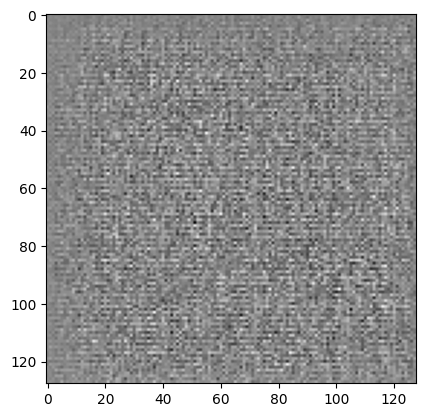

In [ ]:
# Innitialize and test generator model
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
# Innitialize and test discriminator model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 256)      

# Generator and Discriminator Loss & Optimizers

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [ ]:
# Checkpoints
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training Loop

In [ ]:
def add_noise(images, noise_stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=noise_stddev)
    return images + noise

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      generated_images = add_noise(generated_images)
      images = add_noise(images)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# Generate and Save images for the GIF

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

# Output in full rgb, must be np.array for astype
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((np.array(predictions[i]) * 127.5 + 127.5).astype('uint8'))
      plt.axis('off')


  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Training the model

In [ ]:
train(normalized_dataset, EPOCHS)

# Creating the GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-62-7bf4361c5c08>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-62-7bf4361c5c08>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



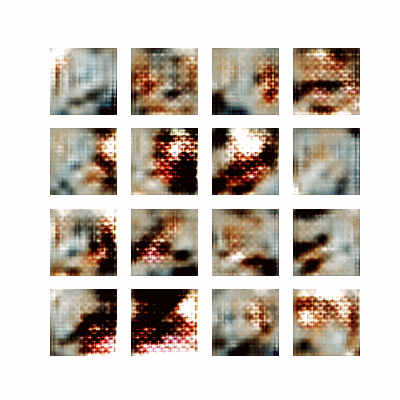

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# Discussion Questions

**Discuss the trade-off between generating high-quality images and maintaining diversity in the output. Are the generated images too similar, or does the model capture a wide range of bedroom styles?**

The relationship of quality and diversity are two sides of the same coin. If the model is over trained to the data set it will grenerate very high quality photos but they will be extremely similar to the data set. The less constrained to the dataset the model is the more creative the output.

The final output of the generator showcases many different layouts of rooms but the generated images all use similar colors in the output.


**Consider potential enhancements to the model architecture or training process. Would experimenting with different hyperparameters or batch sizes yield better results?**

Using a smaller batch size would help diversify the generator's output. I would lower the batch size from 256 to 64. If I had unlimited time and resources, I would increase the amount of layers in the generator and discriminator to increase the amount of high level features captured. Finally, I would increase the input images from 128x128 to 256x256. These changes would create a better output for the model while increasing the training time greatly.

**What are the practical applications for this type of generative model?**

One great use case for GAN's is creating realistic images for use in other datasets. A company could use the output to create fake medical records to protect their clients data in the case of a breach. Another common use for GAN's would be for detecting outliers in a system quickly after being trained on what normal data looks like. GAN's were also used to develop voice systhesis models.